# Project Image Recognition: CNN classifier for 10 monkey species

## Introduction

* This project uses data publically available through Kaggle. The data involves 1300-1400 images of 10 different monkey species. Each image has a size of 400x300 or more size. The original data can be found at the following source. 
    * Source: https://www.kaggle.com/slothkong/10-monkey-species

* The ten monkey species are listed below. 

| Species Name | Common Name |
                  | ------  | ------ |
  | Alouatta Palliata |         Mantled Howler |
| Erythrocebus Patas	|  Patas Monkey |
| Cacajao Calvus | Bald Uakari |
| Macaca Fuscata | Japanese Macaque |
| Cebuella Pygmea | Pygmy Marmoset |
| Cebus Capucinus | White Headed Capuchin |
| Mico Argentatus | Silvery Marmoset |
| Saimiri Sciureus | Common Squirrel Monkey |
| Aotus Nigriceps	| Black Headed Night Monkey |
| Trachypithecus Johnii | Nilgiri Langur |

* All of the classes have 131-152 images for training and 26-30 for Validation. More information on the dataset can be found at the Kaggle pace for the dataset.


* This project applies a Convolutional Neural Network( CNN) model to the classification task to study fine grain classfication problems. Fine grain classifcation refers to the detailed classification problem rather than identifying a general class type such as monkey. 

## Design 
* To experiment and improve the deep learning model's performance, multiple models each with the same architecture and a different learning rate are instantiated, trained, and tested. 
    * The different learning rates for different models were divided into two sets of trials:
        * Trials 1-4 were to find a high performance range of learning rates 
        * Trials 5-7 were to identify an optimal learning rate in that range
    * The learning rates tested were:
        * Trial 1: LR = 0.01
        * Trial 2: LR = 0.001
        * Trial 3: LR = 0.0001
        * Trial 4: LR = 0.00001
        
        * Trial 5: LR = 0.0003
        * Trial 6: LR = 0.0005
        * Trial 7: LR = 0.0008
 
* This notebook includes Trials 1-4 

### Install the required packages 

In [0]:
#Start by setting up PyTorch and other requirements
!pip3 install torch torchvision

In [2]:
#Import Statements
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils,datasets, models
import PIL.Image
from google.colab import files
import zipfile
import io
from torch.utils.data.sampler import SubsetRandomSampler

from matplotlib import pyplot as plt
from google.colab import files

print("All libraries have been imported successfully")

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("Training on CPU")
else:
    print("Cuda is available. Training on GPU")

All libraries have been imported successfully
Cuda is available. Training on GPU


In [0]:
#Load the training data zip
uploaded = files.upload()


In [0]:
#Unzip the training zip
zf = zipfile.ZipFile(io.BytesIO(uploaded['train2.zip']), "r")
zf.extractall()


In [0]:
#Load the validation data zip
validloaded = files.upload()


In [0]:
#Unzip the validation zip
zf2 = zipfile.ZipFile(io.BytesIO(validloaded['valid.zip']), "r")
zf2.extractall()

##  Building the Dataset

* The training and test data are derived from the train.zip image dataset through random sampling. 
* The validation data is derived from the entirety of the valid.zip

* Unique Ideas/Aspects(Find a better word/phrasing)
    * The transforms normalize the train, test, and validation data to a range of [-2,2]. This wider than normal normalization was intentionally designed to increase the range of possible values for image pixels. This dataset in particular contains both drastically differing and overlapping class attributes for different monkey species. A wider normalization was chosen so that the increased range of possible values would allow for greater differentiation by the model for different image pixel values.


In [4]:
#Create The test and train set

#Parameters for Train/Test Splitting
num_workers = 0
batch_size= 137
data_dir = 'train'
test_size = 0.25

#Tranforms for the training and test dataset
#    The images are resized to 128x128. The random horizontal and vertical flip increase the learning potential of the network
#    The Normalize function normalizes all values in the image matrix to [-2,2]. This greater range over the traditional [-1,1] or [0,1] was chosen 
#         to increase the range of possible values, which should allow further differentiation between different image pixel values
data_train_transforms = transforms.Compose([transforms.Resize((128,128)), transforms.RandomHorizontalFlip(p=0.3),transforms.RandomVerticalFlip(p=0.3) , 
                                            transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.25,0.25,0.25])])
data_test_transforms = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.25,0.25,0.25])])

#Import the training Image folder. 
#Import the training Image folder a second time as 'test_data' because the transforms for the test and training set are different.
train_data =  datasets.ImageFolder(data_dir, transform = data_train_transforms)
test_data = datasets.ImageFolder(data_dir, transform = data_test_transforms)

#Randomly split indices based on test_size fraction
#Total 1096 images
#Training: 822
#Test: 274

count_train = len(train_data)
train_indices = list(range(count_train))
np.random.shuffle(train_indices)
traintestsplit = int(np.floor(test_size * count_train))
traindata_idx, testdata_idx = train_indices[traintestsplit:], train_indices[:traintestsplit]

train_sampler = SubsetRandomSampler(traindata_idx)
test_sampler = SubsetRandomSampler(testdata_idx)

#Create the training and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = train_sampler, num_workers=num_workers)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, sampler = test_sampler, num_workers = num_workers)
print("The Train and Test dataloaders were created")

The Train and Test dataloaders were created


In [0]:
# Create the Validation dataset

#Define the transforms for the dataset
data_valid_transforms = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.25,0.25,0.25])])

#Import the validation dataset
valid_dir = 'valid'
valid_data = datasets.ImageFolder(valid_dir, transform = data_valid_transforms)

#Create the validation dataloader
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size= 90, shuffle=True)
print("The Validation dataloader was defined")

The Validation dataloader was defined


* The following training, validation and test datasets were created with their corresponding dataloaders



             
| Dataset | Images | 
      |------|------|
|Training | 822 |
| Test  | 274 |
| Valid | 274 |
| 


## Building the CNN Model


In [0]:
#Define the CNN model

class MonkeySpeciesCNN(nn.Module):
    def __init__(self):
        super(MonkeySpeciesCNN, self).__init__()
        #Input is 128x128x3 tensor
        self.conv1 = nn.Conv2d(3, 16,4, padding =1, stride =2)
        #Batch Normalization on layer outputs
        self.conv1_BN = nn.BatchNorm2d(16)
        #Input is 64x64x16
        
        self.conv2 = nn.Conv2d(16, 32,3, padding =1)
        self.conv2_BN = nn.BatchNorm2d(32)
        #Input is 32x32x32 
        self.conv3 = nn.Conv2d(32,64,3,  padding = 1)
        self.conv3_BN = nn.BatchNorm2d(64)
        #Output is 16x16x64
        
        #max pooling Layer
        self.pool = nn.MaxPool2d(2,2)
        #linear layer(4*4*512)
        self.fc1 = nn.Linear(4096, 100)
        self.fc2 = nn.Linear(100, 1000)
        self.fc3 = nn.Linear(1000, 10)
        self.dropout =  nn.Dropout(0.25)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1_BN(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_BN(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_BN(self.conv3(x))))
        
        x = x.view(-1,8*64*8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x),dim=1)
        return x

classes = ['monkey1', 'monkey2', 'monkey3', 'monkey4', 'monkey5', 'monkey6', 'monkey7',
          'monkey8', 'monkey9','monkey10']

print("The Monkey Species CNN class was successfully defined")
    

The Monkey Species CNN class was successfully defined


## Trial 1: LR = 0.01

In [0]:
#Define the model
#The following notation was used: 
#    MonkeyClassifier1: model for Trial 1(LR = 0.01)

MonkeyClassifier1 = MonkeySpeciesCNN()
#Print the model
print(MonkeyClassifier1)


MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
#Define the Criterion, Optimizer, and move the model to the GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(MonkeyClassifier1.parameters(), lr=0.01)
MonkeyClassifier1.to(device)



MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

Epoch: 0 	Training Loss: 3.867881 	Validation Loss: 2.310529
Epoch: 1 	Training Loss: 1.730027 	Validation Loss: 2.305127
Epoch: 2 	Training Loss: 1.729478 	Validation Loss: 2.303952
Epoch: 3 	Training Loss: 1.726977 	Validation Loss: 2.303908
Epoch: 4 	Training Loss: 1.726496 	Validation Loss: 2.302964
Epoch: 5 	Training Loss: 1.725349 	Validation Loss: 2.302330
Epoch: 6 	Training Loss: 1.726304 	Validation Loss: 2.302199
Epoch: 7 	Training Loss: 1.726777 	Validation Loss: 2.302486
Epoch: 8 	Training Loss: 1.727008 	Validation Loss: 2.302234
Epoch: 9 	Training Loss: 1.727783 	Validation Loss: 2.302579
Epoch: 10 	Training Loss: 1.728256 	Validation Loss: 2.302498
Epoch: 11 	Training Loss: 1.726709 	Validation Loss: 2.302206
Epoch: 12 	Training Loss: 1.727143 	Validation Loss: 2.302381
Epoch: 13 	Training Loss: 1.725441 	Validation Loss: 2.302040
Epoch: 14 	Training Loss: 1.726731 	Validation Loss: 2.301918
Epoch: 15 	Training Loss: 1.726895 	Validation Loss: 2.301990
Epoch: 16 	Trainin

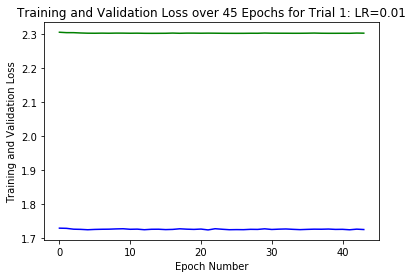

In [0]:
#Train the model

n_epochs = 45

trainLossList1 = []
validLossList1 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    #Train the model on the training data
    MonkeyClassifier1.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        logps = MonkeyClassifier1(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer1.step()
        train_loss += loss.item()*inputs.size(0)
        
    train_loss = train_loss/len(train_dataloader.dataset)
    
    #Validate the model on the validation data
    MonkeyClassifier1.eval()
    for vinputs, vlabels in valid_dataloader:
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        output = MonkeyClassifier1(vinputs)
        vloss = criterion(output,vlabels)
        valid_loss += vloss.item()*vinputs.size(0)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    if epoch != 0:
        trainLossList1.append(train_loss)
        validLossList1.append(valid_loss)
        
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss, valid_loss))
    
#Save the network weights
torch.save(MonkeyClassifier1.state_dict(), 'monkeyModelWeightsTrial1.pth')



fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainLossList1)), trainLossList1, 'b')
plt.plot(np.arange(len(validLossList1)), validLossList1, 'g')
plt.ylabel('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.title('Training and Validation Loss over 45 Epochs for Trial 1: LR=0.01')
plt.show()



In [0]:
files.download('monkeyModelWeightsTrial1.pth')

In [0]:
# Predict classes for Test Dataset 1

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


MonkeyClassifier1.eval()

for data, target in test_dataloader:
    data, target = data.cuda(), target.cuda()
    output = MonkeyClassifier1(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output,1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(1,batch_size): 
        label = target.data[i-1]
        class_correct[label] += correct[i].item()
        class_total[label] +=1
    
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(0,10):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %( classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.576847

Test Accuracy of monkey1:  3% ( 1/26)
Test Accuracy of monkey2:  6% ( 2/30)
Test Accuracy of monkey3:  5% ( 1/20)
Test Accuracy of monkey4: 13% ( 4/29)
Test Accuracy of monkey5:  6% ( 2/31)
Test Accuracy of monkey6:  4% ( 1/25)
Test Accuracy of monkey7: 10% ( 3/29)
Test Accuracy of monkey8: 11% ( 3/27)
Test Accuracy of monkey9:  6% ( 2/32)
Test Accuracy of monkey10:  0% ( 0/23)

Test Accuracy (Overall):  6% (19/272)


## Trial 2: LR = 0.001

In [0]:
#Define the model

MonkeyClassifier2 = MonkeySpeciesCNN()
#Print the model
print(MonkeyClassifier2)


MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
#Define the Criterion, Optimizer, and move the model to the GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(MonkeyClassifier2.parameters(), lr=0.001)
MonkeyClassifier2.to(device)

MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

Epoch: 0 	Training Loss: 1.675562 	Validation Loss: 2.283037
Epoch: 1 	Training Loss: 1.494736 	Validation Loss: 2.215670
Epoch: 2 	Training Loss: 1.340486 	Validation Loss: 2.134222
Epoch: 3 	Training Loss: 1.251716 	Validation Loss: 1.971517
Epoch: 4 	Training Loss: 1.152459 	Validation Loss: 1.712817
Epoch: 5 	Training Loss: 1.105565 	Validation Loss: 1.546655
Epoch: 6 	Training Loss: 1.062496 	Validation Loss: 1.446550
Epoch: 7 	Training Loss: 1.030435 	Validation Loss: 1.438270
Epoch: 8 	Training Loss: 0.950062 	Validation Loss: 1.316810
Epoch: 9 	Training Loss: 0.913559 	Validation Loss: 1.243832
Epoch: 10 	Training Loss: 0.850686 	Validation Loss: 1.235369
Epoch: 11 	Training Loss: 0.815829 	Validation Loss: 1.208634
Epoch: 12 	Training Loss: 0.773207 	Validation Loss: 1.165333
Epoch: 13 	Training Loss: 0.747271 	Validation Loss: 1.119764
Epoch: 14 	Training Loss: 0.707466 	Validation Loss: 1.136533
Epoch: 15 	Training Loss: 0.701752 	Validation Loss: 1.116459
Epoch: 16 	Trainin

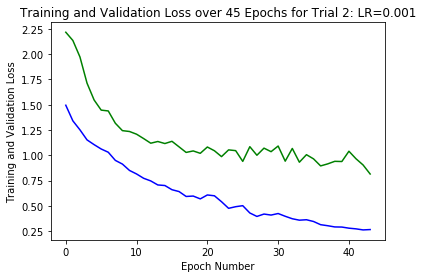

In [0]:
#Train the model

n_epochs = 45

trainLossList2 = []
validLossList2 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    #Train the model on the training data
    MonkeyClassifier2.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()
        logps = MonkeyClassifier2(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()*inputs.size(0)
        
    train_loss = train_loss/len(train_dataloader.dataset)
    
    #Validate the model on the validation data
    MonkeyClassifier2.eval()
    for vinputs, vlabels in valid_dataloader:
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        output = MonkeyClassifier2(vinputs)
        vloss = criterion(output,vlabels)
        valid_loss += vloss.item()*vinputs.size(0)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    if epoch != 0:
        trainLossList2.append(train_loss)
        validLossList2.append(valid_loss)
        
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss, valid_loss))
    
#Save the network weights
torch.save(MonkeyClassifier2.state_dict(), 'monkeyModelWeightsTrial2.pth')



fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainLossList2)), trainLossList2, 'b')
plt.plot(np.arange(len(validLossList2)), validLossList2, 'g')
plt.ylabel('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.title('Training and Validation Loss over 45 Epochs for Trial 2: LR=0.001')
plt.show()


In [0]:
files.download('monkeyModelWeightsTrial2.pth')

In [0]:
# Predict classes for Test Dataset 

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


MonkeyClassifier2.eval()

for data, target in test_dataloader:
    data, target = data.cuda(), target.cuda()
    output = MonkeyClassifier2(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output,1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(1,batch_size): 
        label = target.data[i-1]
        class_correct[label] += correct[i].item()
        class_total[label] +=1
    
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(0,10):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %( classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.267555

Test Accuracy of monkey1: 61% (16/26)
Test Accuracy of monkey2: 66% (20/30)
Test Accuracy of monkey3: 65% (13/20)
Test Accuracy of monkey4: 82% (24/29)
Test Accuracy of monkey5: 67% (21/31)
Test Accuracy of monkey6: 76% (19/25)
Test Accuracy of monkey7: 71% (20/28)
Test Accuracy of monkey8: 59% (16/27)
Test Accuracy of monkey9: 71% (23/32)
Test Accuracy of monkey10: 70% (17/24)

Test Accuracy (Overall): 69% (189/272)


## Trial 3: LR = 0.0001

In [0]:
#Define the model

MonkeyClassifier3 = MonkeySpeciesCNN()
#Print the model
print(MonkeyClassifier3)


MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
#Define the Criterion, Optimizer, and move the model to the GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(MonkeyClassifier3.parameters(), lr=0.0001)
MonkeyClassifier3.to(device)

MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

Epoch: 0 	Training Loss: 1.724085 	Validation Loss: 2.302453
Epoch: 1 	Training Loss: 1.700925 	Validation Loss: 2.299079
Epoch: 2 	Training Loss: 1.680841 	Validation Loss: 2.288067
Epoch: 3 	Training Loss: 1.643960 	Validation Loss: 2.257789
Epoch: 4 	Training Loss: 1.600391 	Validation Loss: 2.199277
Epoch: 5 	Training Loss: 1.560425 	Validation Loss: 2.116315
Epoch: 6 	Training Loss: 1.517464 	Validation Loss: 2.034925
Epoch: 7 	Training Loss: 1.476469 	Validation Loss: 1.963131
Epoch: 8 	Training Loss: 1.447319 	Validation Loss: 1.898164
Epoch: 9 	Training Loss: 1.393238 	Validation Loss: 1.848533
Epoch: 10 	Training Loss: 1.371459 	Validation Loss: 1.809134
Epoch: 11 	Training Loss: 1.334910 	Validation Loss: 1.773200
Epoch: 12 	Training Loss: 1.299316 	Validation Loss: 1.752855
Epoch: 13 	Training Loss: 1.285208 	Validation Loss: 1.718356
Epoch: 14 	Training Loss: 1.277493 	Validation Loss: 1.684097
Epoch: 15 	Training Loss: 1.236933 	Validation Loss: 1.666068
Epoch: 16 	Trainin

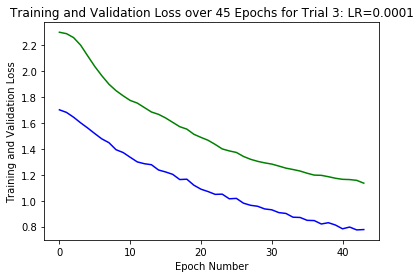

In [0]:
#Train the model

n_epochs = 45

trainLossList3 = []
validLossList3 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    #Train the model on the training data
    MonkeyClassifier3.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer3.zero_grad()
        logps = MonkeyClassifier3(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer3.step()
        train_loss += loss.item()*inputs.size(0)
        
    train_loss = train_loss/len(train_dataloader.dataset)
    
    #Validate the model on the validation data
    MonkeyClassifier3.eval()
    for vinputs, vlabels in valid_dataloader:
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        output = MonkeyClassifier3(vinputs)
        vloss = criterion(output,vlabels)
        valid_loss += vloss.item()*vinputs.size(0)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    if epoch != 0:
        trainLossList3.append(train_loss)
        validLossList3.append(valid_loss)
        
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss, valid_loss))
    
#Save the network weights
torch.save(MonkeyClassifier3.state_dict(), 'monkeyModelWeightsTrial3.pth')



fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainLossList3)), trainLossList3, 'b')
plt.plot(np.arange(len(validLossList3)), validLossList3, 'g')
plt.ylabel('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.title('Training and Validation Loss over 45 Epochs for Trial 3: LR=0.0001')
plt.show()


In [0]:
files.download('monkeyModelWeightsTrial3.pth')

In [0]:
# Predict classes for Test Dataset 

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


MonkeyClassifier3.eval()

for data, target in test_dataloader:
    data, target = data.cuda(), target.cuda()
    output = MonkeyClassifier3(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output,1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(1,batch_size): 
        label = target.data[i-1]
        class_correct[label] += correct[i].item()
        class_total[label] +=1
    
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(0,10):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %( classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.259393

Test Accuracy of monkey1: 76% (20/26)
Test Accuracy of monkey2: 54% (17/31)
Test Accuracy of monkey3: 75% (15/20)
Test Accuracy of monkey4: 64% (18/28)
Test Accuracy of monkey5: 60% (18/30)
Test Accuracy of monkey6: 64% (16/25)
Test Accuracy of monkey7: 72% (21/29)
Test Accuracy of monkey8: 74% (20/27)
Test Accuracy of monkey9: 56% (18/32)
Test Accuracy of monkey10: 70% (17/24)

Test Accuracy (Overall): 66% (180/272)


## Trial 4: LR = 0.00001

In [0]:
#Define the model

MonkeyClassifier4 = MonkeySpeciesCNN()
#Print the model
print(MonkeyClassifier4)

MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
#Define the Criterion, Optimizer, and move the model to the GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(MonkeyClassifier4.parameters(), lr=0.00001)
MonkeyClassifier4.to(device)

MonkeySpeciesCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

Epoch: 0 	Training Loss: 1.734897 	Validation Loss: 2.303103
Epoch: 1 	Training Loss: 1.727949 	Validation Loss: 2.302971
Epoch: 2 	Training Loss: 1.727664 	Validation Loss: 2.302400
Epoch: 3 	Training Loss: 1.726247 	Validation Loss: 2.300874
Epoch: 4 	Training Loss: 1.721569 	Validation Loss: 2.298420
Epoch: 5 	Training Loss: 1.720898 	Validation Loss: 2.295191
Epoch: 6 	Training Loss: 1.717581 	Validation Loss: 2.291751
Epoch: 7 	Training Loss: 1.718390 	Validation Loss: 2.288402
Epoch: 8 	Training Loss: 1.718181 	Validation Loss: 2.285232
Epoch: 9 	Training Loss: 1.715976 	Validation Loss: 2.282221
Epoch: 10 	Training Loss: 1.713383 	Validation Loss: 2.279407
Epoch: 11 	Training Loss: 1.714162 	Validation Loss: 2.276607
Epoch: 12 	Training Loss: 1.707940 	Validation Loss: 2.273879
Epoch: 13 	Training Loss: 1.704306 	Validation Loss: 2.271077
Epoch: 14 	Training Loss: 1.707089 	Validation Loss: 2.268115
Epoch: 15 	Training Loss: 1.698335 	Validation Loss: 2.264874
Epoch: 16 	Trainin

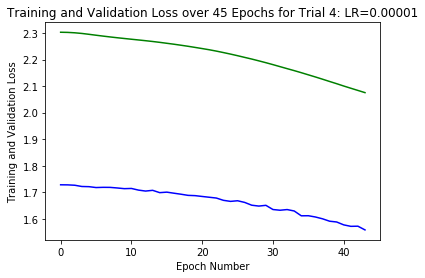

In [0]:
#Train the model

n_epochs = 45

trainLossList4 = []
validLossList4 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    #Train the model on the training data
    MonkeyClassifier4.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer4.zero_grad()
        logps = MonkeyClassifier4(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer4.step()
        train_loss += loss.item()*inputs.size(0)
        
    train_loss = train_loss/len(train_dataloader.dataset)
    
    #Validate the model on the validation data
    MonkeyClassifier4.eval()
    for vinputs, vlabels in valid_dataloader:
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        output = MonkeyClassifier4(vinputs)
        vloss = criterion(output,vlabels)
        valid_loss += vloss.item()*vinputs.size(0)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    if epoch != 0:
        trainLossList4.append(train_loss)
        validLossList4.append(valid_loss)
        
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss, valid_loss))
    
#Save the network weights
torch.save(MonkeyClassifier4.state_dict(), 'monkeyModelWeightsTrial4.pth')



fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainLossList4)), trainLossList4, 'b')
plt.plot(np.arange(len(validLossList4)), validLossList4, 'g')
plt.ylabel('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.title('Training and Validation Loss over 45 Epochs for Trial 4: LR=0.00001')
plt.show()

In [0]:
files.download('monkeyModelWeightsTrial4.pth')

In [0]:
# Predict classes for Test Dataset 

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


MonkeyClassifier4.eval()

for data, target in test_dataloader:
    data, target = data.cuda(), target.cuda()
    output = MonkeyClassifier4(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output,1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(1,batch_size): 
        label = target.data[i-1]
        class_correct[label] += correct[i].item()
        class_total[label] +=1
    
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(0,10):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %( classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.513155

Test Accuracy of monkey1: 15% ( 4/26)
Test Accuracy of monkey2: 23% ( 7/30)
Test Accuracy of monkey3: 30% ( 6/20)
Test Accuracy of monkey4: 31% ( 9/29)
Test Accuracy of monkey5: 38% (12/31)
Test Accuracy of monkey6: 32% ( 8/25)
Test Accuracy of monkey7: 24% ( 7/29)
Test Accuracy of monkey8: 57% (15/26)
Test Accuracy of monkey9: 15% ( 5/32)
Test Accuracy of monkey10: 37% ( 9/24)

Test Accuracy (Overall): 30% (82/272)


Text(0, 0.5, 'Training Loss')

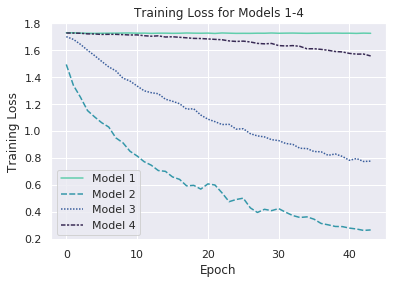

In [0]:
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
#trainingLoss_df = pd.DataFrame(
#                    { 'Model R1': trainingLossList1,
#                      'Model R2': trainingLossList2,
#                      'Model R3': trainingLossList3,
#                      'Model R4': trainingLossList4
#                      'Model R5': trainingLossList5
#                    })

trainingLoss_df = pd.DataFrame(list(zip(trainLossList1, trainLossList2, trainLossList3, trainLossList4)),
                              columns = ['Model 1','Model 2','Model 3','Model 4'])
palette = sns.color_palette("mako_r", 4)
ax = sns.lineplot(data=trainingLoss_df, palette=palette).set_title('Training Loss for Models 1-4')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')



Text(0, 0.5, 'Validation Loss')

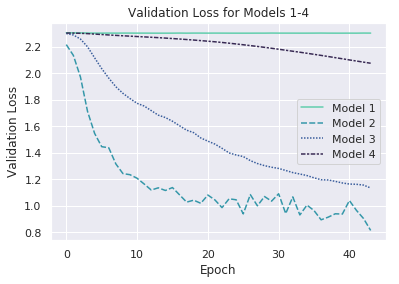

In [0]:
validLoss_df = pd.DataFrame(list(zip(validLossList1, validLossList2, validLossList3, validLossList4)),
                              columns = ['Model 1','Model 2','Model 3','Model 4'])
palette = sns.color_palette("mako_r", 4)
ax = sns.lineplot(data=validLoss_df, palette=palette).set_title('Validation Loss for Models 1-4')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
